<a href="https://colab.research.google.com/github/FaizKmt/Tugas_DL_TM4/blob/main/Malaria_Cell_Image_Classification_with_CNN_96_Acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cell-images-for-detecting-malaria:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F87153%2F200743%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T164447Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D39bfd0d38bdca0a2250c2f4907c5644c8e53ee04b53e36794f081c3a06c6968e20abcdf29c11809574eaa2c36725b64f9f7707b0a7034c8e4d092426eafb89b58cb55e0b85f99232bd31d1b301bff3212bb7d0cf5d4b9d3d91afd585e4d09b0721f1d80532c27db4423a2da901ac1895de7d7c12c8e29ede7851186b5fd9767dee5c0f4ab914b0df4834c24c55cfcf7e333b679b7b81c1d2063a7d2ea44a4ae253bd8878a6087cb94cf239676559c1f6a6170d1b5729cc27a548762998d8763c0f9b9bfb354e34695cab07e961a888d6caa417320e5d2ee3ce721c58b757072b4b10cb657f431d29ca944ec3fa92ef7546b0855a774fec464477963fbd756c2d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 708172590 bytes downloaded
Downloaded and uncompressed: cell-images-for-detecting-malaria
Data source import complete.


# Importing neccessary libraries

In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Displaying Uninfected and Infected Cell tissues

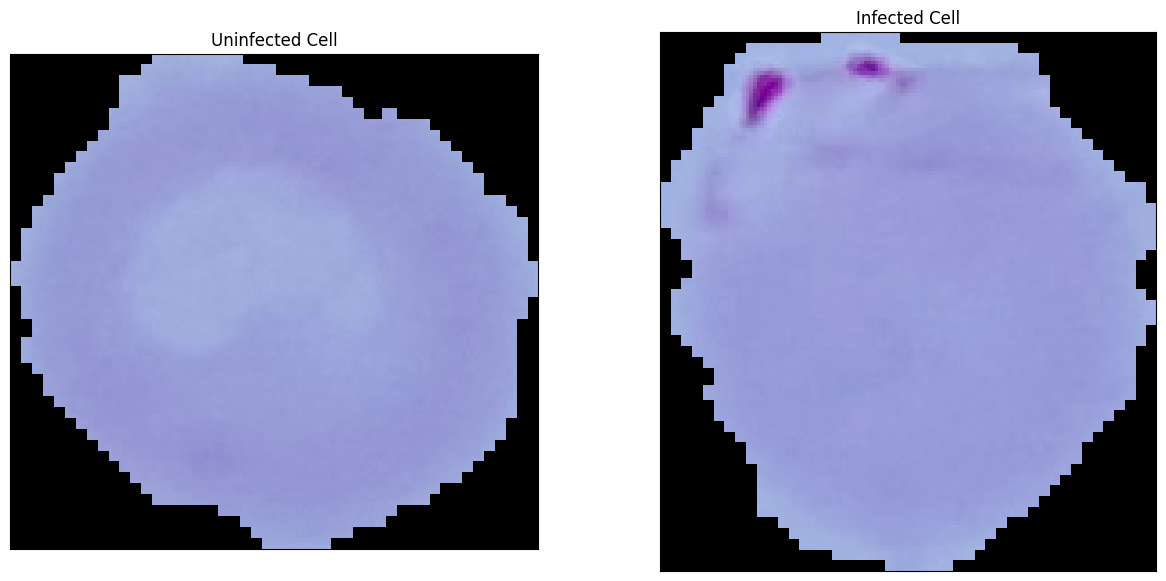

In [7]:
import cv2

upic='../input/cell-images-for-detecting-malaria/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_131.png'
apic='../input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png'
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cv2.imread(upic))
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cv2.imread(apic))
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

In [8]:
width = 128
height = 128

# Dividing Dataset into two folders train and test

In [9]:
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

# Preparing train and test Image Generator

In [10]:
trainDatagen = datagen.flow_from_directory(directory='../input/cell-images-for-detecting-malaria/cell_images/cell_images/',
                                           target_size=(width,height),
                                           class_mode = 'binary',
                                           batch_size = 16,
                                           subset='training')

Found 22048 images belonging to 2 classes.


In [11]:
valDatagen = datagen.flow_from_directory(directory='../input/cell-images-for-detecting-malaria/cell_images/cell_images/',
                                           target_size=(width,height),
                                           class_mode = 'binary',
                                           batch_size = 16,
                                           subset='validation')

Found 5510 images belonging to 2 classes.


# Preparing the model

In [12]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 32)        0

In [14]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [17]:
history = model.fit_generator(generator = trainDatagen,
                             steps_per_epoch = len(trainDatagen),
                              epochs =20,
                              validation_data = valDatagen,
                              validation_steps=len(valDatagen),
                             callbacks=[early_stop])

Epoch 1/20


<ipython-input-17-54369da054e7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = trainDatagen,


1378/1378 [==============================] - 206s 149ms/step - loss: 0.5089 - accuracy: 0.7344 - val_loss: 0.2101 - val_accuracy: 0.9263
Epoch 2/20
1378/1378 [==============================] - 205s 149ms/step - loss: 0.2034 - accuracy: 0.9332 - val_loss: 0.1630 - val_accuracy: 0.9350
Epoch 3/20
1378/1378 [==============================] - 218s 158ms/step - loss: 0.1710 - accuracy: 0.9466 - val_loss: 0.1806 - val_accuracy: 0.9423
Epoch 4/20
1378/1378 [==============================] - 205s 149ms/step - loss: 0.1566 - accuracy: 0.9532 - val_loss: 0.1883 - val_accuracy: 0.9419


# Plots

In [25]:
def plotLearningCurve(history, epochs):
    acc_values = history.history['accuracy']
    val_acc_values = history.history['val_accuracy']
    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']

    epochRange = range(1, len(acc_values) + 1)  # Sesuaikan panjang epochRange dengan panjang data yang ada

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochRange, acc_values, label='Training Accuracy')
    plt.plot(epochRange, val_acc_values, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochRange, loss_values, label='Training Loss')
    plt.plot(epochRange, val_loss_values, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

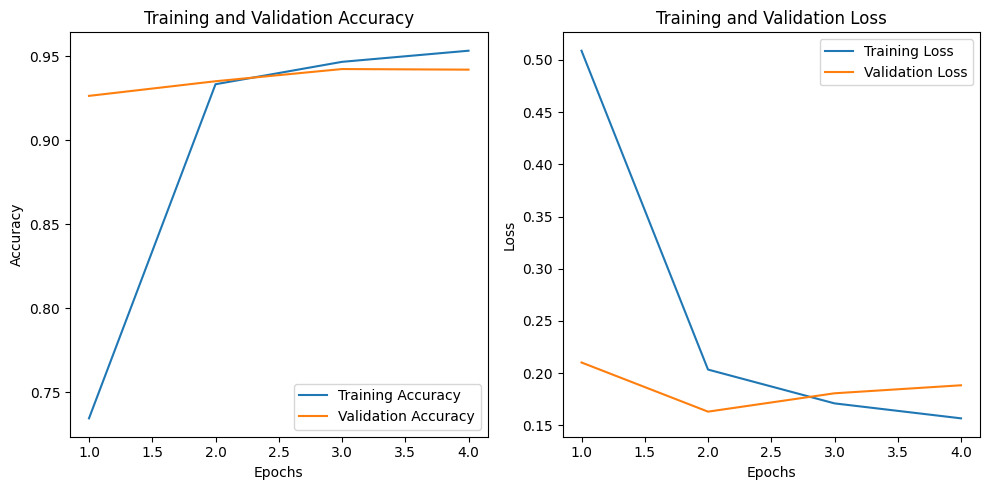

In [26]:
plotLearningCurve(history,4)